In [1]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import math
import os
import matplotlib.pyplot as plt

from dataset import DatasetFromFolder
from networks import define_G, define_D, GANLoss, get_scheduler, update_learning_rate
from utils import is_image_file, load_img, save_img

In [2]:
BATCH_SIZE = 4

In [3]:
root_path = "./data/"

train_set = DatasetFromFolder('./data/facades/train', 'b2a')
test_set = DatasetFromFolder('./data/facades/test', 'b2a')

In [4]:
training_data_loader = DataLoader(dataset=train_set, num_workers=4,
                                  batch_size=BATCH_SIZE, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=4,
                                 batch_size=BATCH_SIZE, shuffle=False)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
net_g = define_G(3, 3, 64, 'batch', False, 'normal', 0.02, gpu_id=device)
net_d = define_D(3 + 3, 64, 'basic', gpu_id=device)

initialize network with normal
initialize network with normal


In [7]:
criterionGAN = GANLoss().to(device)
criterionL1 = nn.L1Loss().to(device)
criterionMSE = nn.MSELoss().to(device)

In [8]:
optimizer_g = optim.Adam(net_g.parameters(), lr=2e-3, betas=(0.5, 0.999))
optimizer_d = optim.Adam(net_d.parameters(), lr=2e-3, betas=(0.5, 0.999))
net_g_scheduler = get_scheduler(optimizer_g, 'lambda')
net_d_scheduler = get_scheduler(optimizer_d, 'lambda')

In [9]:
for epoch in range(1, 15):
    # train
    for iteration, batch in enumerate(training_data_loader, 1):
        # forward
        real_a, real_b = batch[0].to(device), batch[1].to(device)
        fake_b = net_g(real_a)

        ######################
        # (1) Update D network
        ######################

        optimizer_d.zero_grad()
        
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = net_d.forward(fake_ab.detach())
        loss_d_fake = criterionGAN(pred_fake, False)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = net_d.forward(real_ab)
        loss_d_real = criterionGAN(pred_real, True)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5

        loss_d.backward()
       
        optimizer_d.step()

        ######################
        # (2) Update G network
        ######################

        optimizer_g.zero_grad()

        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = net_d.forward(fake_ab)
        loss_g_gan = criterionGAN(pred_fake, True)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * 10
        
        loss_g = loss_g_gan + loss_g_l1
        
        loss_g.backward()

        optimizer_g.step()

        print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}".format(
            epoch, iteration, len(training_data_loader), loss_d.item(), loss_g.item()))

    update_learning_rate(net_g_scheduler, optimizer_g)
    update_learning_rate(net_d_scheduler, optimizer_d)

    # test
    avg_psnr = 0
    for batch in testing_data_loader:
        input, target = batch[0].to(device), batch[1].to(device)

        prediction = net_g(input)
        mse = criterionMSE(prediction, target)
        psnr = 10 * math.log10(1 / mse.item())
        avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

===> Epoch[1](1/100): Loss_D: 1.4685 Loss_G: 145.2177
===> Epoch[1](2/100): Loss_D: 101.4335 Loss_G: 226.5602
===> Epoch[1](3/100): Loss_D: 206.1699 Loss_G: 92.5321
===> Epoch[1](4/100): Loss_D: 68.8460 Loss_G: 11.8551
===> Epoch[1](5/100): Loss_D: 4.0763 Loss_G: 10.0280
===> Epoch[1](6/100): Loss_D: 2.9425 Loss_G: 8.3598
===> Epoch[1](7/100): Loss_D: 2.5650 Loss_G: 6.4455
===> Epoch[1](8/100): Loss_D: 1.0641 Loss_G: 5.0713
===> Epoch[1](9/100): Loss_D: 0.7980 Loss_G: 4.8037
===> Epoch[1](10/100): Loss_D: 0.5660 Loss_G: 5.3847
===> Epoch[1](11/100): Loss_D: 0.4077 Loss_G: 4.2320
===> Epoch[1](12/100): Loss_D: 0.3626 Loss_G: 4.3775
===> Epoch[1](13/100): Loss_D: 0.3176 Loss_G: 4.2951
===> Epoch[1](14/100): Loss_D: 0.3146 Loss_G: 4.6748
===> Epoch[1](15/100): Loss_D: 0.3229 Loss_G: 5.0099
===> Epoch[1](16/100): Loss_D: 0.2941 Loss_G: 4.1452
===> Epoch[1](17/100): Loss_D: 0.2909 Loss_G: 4.1509
===> Epoch[1](18/100): Loss_D: 0.2672 Loss_G: 4.7730
===> Epoch[1](19/100): Loss_D: 0.2784 Loss_

===> Epoch[2](55/100): Loss_D: 0.2543 Loss_G: 4.1234
===> Epoch[2](56/100): Loss_D: 0.2839 Loss_G: 4.5291
===> Epoch[2](57/100): Loss_D: 0.2635 Loss_G: 4.0679
===> Epoch[2](58/100): Loss_D: 0.2285 Loss_G: 4.3256
===> Epoch[2](59/100): Loss_D: 0.2933 Loss_G: 4.6562
===> Epoch[2](60/100): Loss_D: 0.2629 Loss_G: 4.6799
===> Epoch[2](61/100): Loss_D: 0.2861 Loss_G: 4.2412
===> Epoch[2](62/100): Loss_D: 0.3574 Loss_G: 3.6752
===> Epoch[2](63/100): Loss_D: 0.3956 Loss_G: 4.4236
===> Epoch[2](64/100): Loss_D: 0.3748 Loss_G: 4.7252
===> Epoch[2](65/100): Loss_D: 0.3995 Loss_G: 4.8883
===> Epoch[2](66/100): Loss_D: 0.3489 Loss_G: 4.1884
===> Epoch[2](67/100): Loss_D: 0.3679 Loss_G: 3.1078
===> Epoch[2](68/100): Loss_D: 0.3556 Loss_G: 3.8612
===> Epoch[2](69/100): Loss_D: 0.4285 Loss_G: 4.2143
===> Epoch[2](70/100): Loss_D: 0.4633 Loss_G: 4.2156
===> Epoch[2](71/100): Loss_D: 0.5063 Loss_G: 4.2351
===> Epoch[2](72/100): Loss_D: 0.5354 Loss_G: 3.7627
===> Epoch[2](73/100): Loss_D: 0.4680 Loss_G: 

===> Epoch[4](7/100): Loss_D: 0.2512 Loss_G: 4.2518
===> Epoch[4](8/100): Loss_D: 0.2074 Loss_G: 3.9953
===> Epoch[4](9/100): Loss_D: 0.2323 Loss_G: 3.9882
===> Epoch[4](10/100): Loss_D: 0.2101 Loss_G: 3.7150
===> Epoch[4](11/100): Loss_D: 0.1983 Loss_G: 3.8165
===> Epoch[4](12/100): Loss_D: 0.1951 Loss_G: 3.9985
===> Epoch[4](13/100): Loss_D: 0.2124 Loss_G: 4.2358
===> Epoch[4](14/100): Loss_D: 0.3969 Loss_G: 5.5746
===> Epoch[4](15/100): Loss_D: 0.9411 Loss_G: 5.7667
===> Epoch[4](16/100): Loss_D: 1.4051 Loss_G: 5.0116
===> Epoch[4](17/100): Loss_D: 0.9601 Loss_G: 3.8808
===> Epoch[4](18/100): Loss_D: 0.4723 Loss_G: 4.3381
===> Epoch[4](19/100): Loss_D: 0.8068 Loss_G: 5.6070
===> Epoch[4](20/100): Loss_D: 1.4294 Loss_G: 5.0256
===> Epoch[4](21/100): Loss_D: 1.0595 Loss_G: 5.2882
===> Epoch[4](22/100): Loss_D: 0.6809 Loss_G: 4.4937
===> Epoch[4](23/100): Loss_D: 0.6292 Loss_G: 5.7812
===> Epoch[4](24/100): Loss_D: 0.4472 Loss_G: 4.6752
===> Epoch[4](25/100): Loss_D: 0.2786 Loss_G: 3.8

===> Epoch[5](61/100): Loss_D: 0.5889 Loss_G: 3.5591
===> Epoch[5](62/100): Loss_D: 0.3062 Loss_G: 3.9488
===> Epoch[5](63/100): Loss_D: 0.1602 Loss_G: 4.4771
===> Epoch[5](64/100): Loss_D: 0.3124 Loss_G: 4.2167
===> Epoch[5](65/100): Loss_D: 0.3116 Loss_G: 4.5823
===> Epoch[5](66/100): Loss_D: 0.1949 Loss_G: 4.2986
===> Epoch[5](67/100): Loss_D: 0.1608 Loss_G: 5.0058
===> Epoch[5](68/100): Loss_D: 0.1952 Loss_G: 3.7927
===> Epoch[5](69/100): Loss_D: 0.1257 Loss_G: 4.7048
===> Epoch[5](70/100): Loss_D: 0.1478 Loss_G: 4.3784
===> Epoch[5](71/100): Loss_D: 0.1393 Loss_G: 4.1656
===> Epoch[5](72/100): Loss_D: 0.1609 Loss_G: 3.9181
===> Epoch[5](73/100): Loss_D: 0.2794 Loss_G: 3.6899
===> Epoch[5](74/100): Loss_D: 0.6509 Loss_G: 7.3542
===> Epoch[5](75/100): Loss_D: 1.2586 Loss_G: 4.2498
===> Epoch[5](76/100): Loss_D: 0.7470 Loss_G: 5.2028
===> Epoch[5](77/100): Loss_D: 0.1719 Loss_G: 4.9358
===> Epoch[5](78/100): Loss_D: 0.2451 Loss_G: 4.3387
===> Epoch[5](79/100): Loss_D: 0.2529 Loss_G: 

===> Epoch[7](13/100): Loss_D: 1.5279 Loss_G: 4.4060
===> Epoch[7](14/100): Loss_D: 0.5069 Loss_G: 3.6082
===> Epoch[7](15/100): Loss_D: 0.5258 Loss_G: 5.8820
===> Epoch[7](16/100): Loss_D: 1.1596 Loss_G: 5.6043
===> Epoch[7](17/100): Loss_D: 1.3984 Loss_G: 5.4310
===> Epoch[7](18/100): Loss_D: 0.6860 Loss_G: 5.6191
===> Epoch[7](19/100): Loss_D: 0.9963 Loss_G: 5.7969
===> Epoch[7](20/100): Loss_D: 1.4594 Loss_G: 4.8015
===> Epoch[7](21/100): Loss_D: 2.0445 Loss_G: 6.4482
===> Epoch[7](22/100): Loss_D: 1.9639 Loss_G: 5.2407
===> Epoch[7](23/100): Loss_D: 1.2375 Loss_G: 3.5516
===> Epoch[7](24/100): Loss_D: 0.2903 Loss_G: 4.9209
===> Epoch[7](25/100): Loss_D: 0.4291 Loss_G: 3.9034
===> Epoch[7](26/100): Loss_D: 0.3125 Loss_G: 5.1149
===> Epoch[7](27/100): Loss_D: 0.2738 Loss_G: 4.1100
===> Epoch[7](28/100): Loss_D: 0.2458 Loss_G: 3.8508
===> Epoch[7](29/100): Loss_D: 0.1958 Loss_G: 3.1932
===> Epoch[7](30/100): Loss_D: 0.1950 Loss_G: 4.4909
===> Epoch[7](31/100): Loss_D: 0.2015 Loss_G: 

===> Epoch[8](67/100): Loss_D: 0.3580 Loss_G: 3.5531
===> Epoch[8](68/100): Loss_D: 0.2538 Loss_G: 4.2408
===> Epoch[8](69/100): Loss_D: 0.2080 Loss_G: 3.8984
===> Epoch[8](70/100): Loss_D: 0.1963 Loss_G: 4.5824
===> Epoch[8](71/100): Loss_D: 0.2437 Loss_G: 4.0257
===> Epoch[8](72/100): Loss_D: 0.2943 Loss_G: 3.9177
===> Epoch[8](73/100): Loss_D: 0.2059 Loss_G: 4.1014
===> Epoch[8](74/100): Loss_D: 0.3227 Loss_G: 3.9301
===> Epoch[8](75/100): Loss_D: 0.2236 Loss_G: 4.0470
===> Epoch[8](76/100): Loss_D: 0.3146 Loss_G: 3.4589
===> Epoch[8](77/100): Loss_D: 0.3057 Loss_G: 4.7181
===> Epoch[8](78/100): Loss_D: 0.3688 Loss_G: 4.9858
===> Epoch[8](79/100): Loss_D: 0.4401 Loss_G: 3.9562
===> Epoch[8](80/100): Loss_D: 0.3577 Loss_G: 3.6226
===> Epoch[8](81/100): Loss_D: 0.2839 Loss_G: 4.3177
===> Epoch[8](82/100): Loss_D: 0.2338 Loss_G: 3.9086
===> Epoch[8](83/100): Loss_D: 0.2254 Loss_G: 3.6779
===> Epoch[8](84/100): Loss_D: 0.2127 Loss_G: 3.9211
===> Epoch[8](85/100): Loss_D: 0.1890 Loss_G: 

===> Epoch[10](19/100): Loss_D: 0.2407 Loss_G: 5.0288
===> Epoch[10](20/100): Loss_D: 0.3221 Loss_G: 4.1617
===> Epoch[10](21/100): Loss_D: 0.3553 Loss_G: 3.7856
===> Epoch[10](22/100): Loss_D: 0.2760 Loss_G: 3.5668
===> Epoch[10](23/100): Loss_D: 0.2552 Loss_G: 3.7235
===> Epoch[10](24/100): Loss_D: 0.2143 Loss_G: 4.7562
===> Epoch[10](25/100): Loss_D: 0.2589 Loss_G: 3.8757
===> Epoch[10](26/100): Loss_D: 0.2122 Loss_G: 3.9202
===> Epoch[10](27/100): Loss_D: 0.2040 Loss_G: 3.5400
===> Epoch[10](28/100): Loss_D: 0.3036 Loss_G: 3.7404
===> Epoch[10](29/100): Loss_D: 0.1997 Loss_G: 4.1039
===> Epoch[10](30/100): Loss_D: 0.2087 Loss_G: 3.9359
===> Epoch[10](31/100): Loss_D: 0.2363 Loss_G: 4.2490
===> Epoch[10](32/100): Loss_D: 0.2171 Loss_G: 4.3371
===> Epoch[10](33/100): Loss_D: 0.3402 Loss_G: 3.7476
===> Epoch[10](34/100): Loss_D: 0.2101 Loss_G: 4.7202
===> Epoch[10](35/100): Loss_D: 0.2982 Loss_G: 3.0613
===> Epoch[10](36/100): Loss_D: 0.1979 Loss_G: 3.6238
===> Epoch[10](37/100): Loss

===> Epoch[11](70/100): Loss_D: 0.1693 Loss_G: 4.1455
===> Epoch[11](71/100): Loss_D: 0.2383 Loss_G: 3.7074
===> Epoch[11](72/100): Loss_D: 0.4019 Loss_G: 4.5820
===> Epoch[11](73/100): Loss_D: 0.5725 Loss_G: 3.4001
===> Epoch[11](74/100): Loss_D: 0.2807 Loss_G: 4.2912
===> Epoch[11](75/100): Loss_D: 0.1160 Loss_G: 5.1089
===> Epoch[11](76/100): Loss_D: 0.2472 Loss_G: 3.9690
===> Epoch[11](77/100): Loss_D: 0.3007 Loss_G: 3.9640
===> Epoch[11](78/100): Loss_D: 0.2721 Loss_G: 3.5280
===> Epoch[11](79/100): Loss_D: 0.1994 Loss_G: 4.1542
===> Epoch[11](80/100): Loss_D: 0.1477 Loss_G: 4.5628
===> Epoch[11](81/100): Loss_D: 0.2608 Loss_G: 3.4081
===> Epoch[11](82/100): Loss_D: 0.3125 Loss_G: 3.4206
===> Epoch[11](83/100): Loss_D: 0.2710 Loss_G: 3.6802
===> Epoch[11](84/100): Loss_D: 0.3683 Loss_G: 3.6386
===> Epoch[11](85/100): Loss_D: 0.2440 Loss_G: 3.7399
===> Epoch[11](86/100): Loss_D: 0.1574 Loss_G: 4.1590
===> Epoch[11](87/100): Loss_D: 0.1583 Loss_G: 4.3519
===> Epoch[11](88/100): Loss

===> Epoch[13](20/100): Loss_D: 0.2743 Loss_G: 4.5813
===> Epoch[13](21/100): Loss_D: 0.3123 Loss_G: 3.6666
===> Epoch[13](22/100): Loss_D: 0.2123 Loss_G: 3.3365
===> Epoch[13](23/100): Loss_D: 0.2338 Loss_G: 3.9649
===> Epoch[13](24/100): Loss_D: 0.2331 Loss_G: 3.7610
===> Epoch[13](25/100): Loss_D: 0.1885 Loss_G: 3.9951
===> Epoch[13](26/100): Loss_D: 0.2622 Loss_G: 4.6090
===> Epoch[13](27/100): Loss_D: 0.3293 Loss_G: 4.2822
===> Epoch[13](28/100): Loss_D: 0.2107 Loss_G: 4.1628
===> Epoch[13](29/100): Loss_D: 0.2152 Loss_G: 3.4103
===> Epoch[13](30/100): Loss_D: 0.1599 Loss_G: 4.1658
===> Epoch[13](31/100): Loss_D: 0.2300 Loss_G: 3.9384
===> Epoch[13](32/100): Loss_D: 0.1833 Loss_G: 3.8701
===> Epoch[13](33/100): Loss_D: 0.1650 Loss_G: 4.0812
===> Epoch[13](34/100): Loss_D: 0.2223 Loss_G: 4.5223
===> Epoch[13](35/100): Loss_D: 0.2273 Loss_G: 3.9457
===> Epoch[13](36/100): Loss_D: 0.4228 Loss_G: 4.2943
===> Epoch[13](37/100): Loss_D: 0.3187 Loss_G: 3.4059
===> Epoch[13](38/100): Loss

===> Epoch[14](71/100): Loss_D: 0.1755 Loss_G: 4.7239
===> Epoch[14](72/100): Loss_D: 0.1780 Loss_G: 4.4432
===> Epoch[14](73/100): Loss_D: 0.2228 Loss_G: 3.8758
===> Epoch[14](74/100): Loss_D: 0.2223 Loss_G: 3.4236
===> Epoch[14](75/100): Loss_D: 0.1770 Loss_G: 3.5338
===> Epoch[14](76/100): Loss_D: 0.1811 Loss_G: 4.2323
===> Epoch[14](77/100): Loss_D: 0.2283 Loss_G: 4.9183
===> Epoch[14](78/100): Loss_D: 0.3262 Loss_G: 4.1166
===> Epoch[14](79/100): Loss_D: 0.1980 Loss_G: 4.4173
===> Epoch[14](80/100): Loss_D: 0.2068 Loss_G: 4.2026
===> Epoch[14](81/100): Loss_D: 0.2211 Loss_G: 3.9006
===> Epoch[14](82/100): Loss_D: 0.3012 Loss_G: 3.4091
===> Epoch[14](83/100): Loss_D: 0.2799 Loss_G: 5.5808
===> Epoch[14](84/100): Loss_D: 0.4162 Loss_G: 4.6300
===> Epoch[14](85/100): Loss_D: 0.3675 Loss_G: 4.7997
===> Epoch[14](86/100): Loss_D: 0.3797 Loss_G: 5.1459
===> Epoch[14](87/100): Loss_D: 0.2046 Loss_G: 4.5150
===> Epoch[14](88/100): Loss_D: 0.1990 Loss_G: 4.9829
===> Epoch[14](89/100): Loss

In [10]:
image_dir = "data/facades/test/b/"

image_filenames = [x for x in os.listdir(image_dir) if is_image_file(x)]

transform_list = [transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

transform = transforms.Compose(transform_list)

for image_name in image_filenames:
    img = load_img(image_dir + image_name)
    img = transform(img)
    input = img.unsqueeze(0).to(device)
    out = net_g(input)
    out_img = out.detach().squeeze(0).cpu()

    if not os.path.exists("result"):
        os.makedirs("result")
    save_img(out_img, "result/{}".format(image_name))

Image saved as result/cmp_b0188.png
Image saved as result/cmp_b0090.png
Image saved as result/cmp_x0157.png
Image saved as result/cmp_b0319.png
Image saved as result/cmp_b0105.png
Image saved as result/cmp_b0231.png
Image saved as result/cmp_b0125.png
Image saved as result/cmp_b0202.png
Image saved as result/cmp_b0174.png
Image saved as result/cmp_x0040.png
Image saved as result/cmp_b0340.png
Image saved as result/cmp_x0027.png
Image saved as result/cmp_b0315.png
Image saved as result/cmp_b0199.png
Image saved as result/cmp_b0190.png
Image saved as result/cmp_b0219.png
Image saved as result/cmp_b0126.png
Image saved as result/cmp_x0160.png
Image saved as result/cmp_b0241.png
Image saved as result/cmp_x0107.png
Image saved as result/cmp_b0234.png
Image saved as result/cmp_x0183.png
Image saved as result/cmp_x0116.png
Image saved as result/cmp_x0143.png
Image saved as result/cmp_x0169.png
Image saved as result/cmp_x0223.png
Image saved as result/cmp_x0024.png
Image saved as result/cmp_b0

In [12]:
import random
import matplotlib.image as mpimg

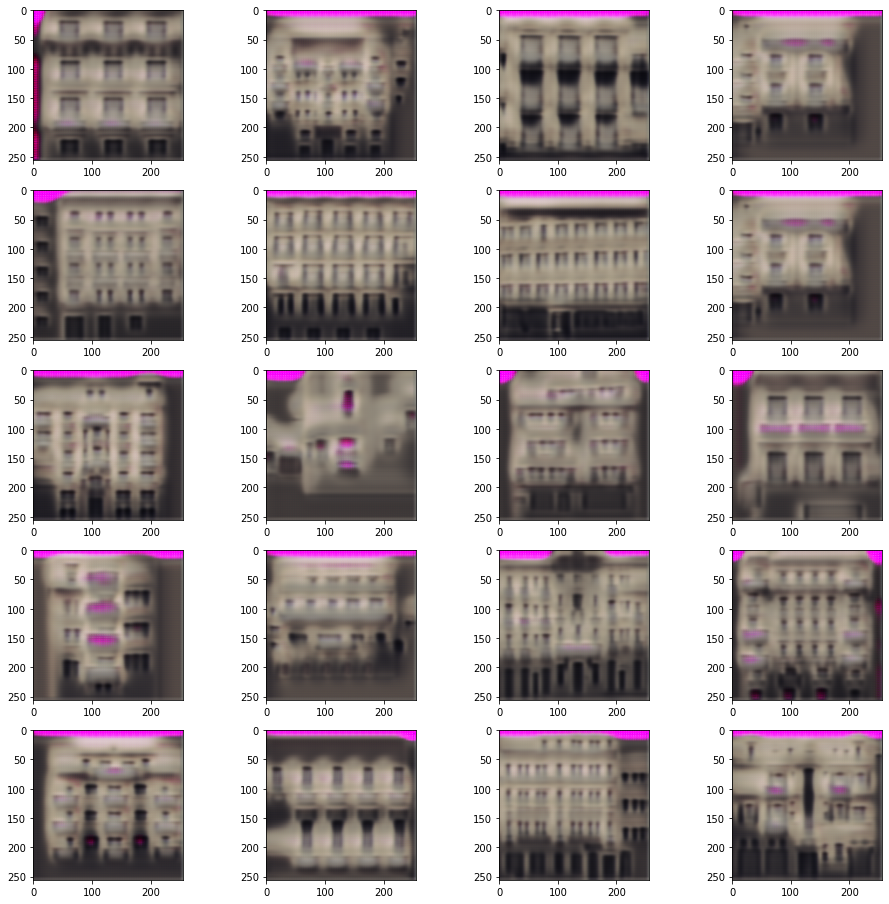

In [14]:
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = os.path.join('result', random.choice(os.listdir('result')))
    img = mpimg.imread(img)
#     img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()